## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from os.path import join
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from trace_lib import trace as tlt
from trace_lib import plots as tlp
from trace_lib import sp

device = 'cuda'

# Read the data

In [2]:
df = pd.read_csv('DAAALabel.csv')
df = df[df.isna()['Notes']]
df.reset_index(inplace=True, drop=True)
df

,File Name,Unnamed: 1,Symptoms of Dizzy during tests,T10,T11,T12,T13,T14,T20,T21,T22,T23,T24,T30,T31,T32,T33,T34,Notes
0,20221017-133409,P1,No,770,779.9,791.9,797.4,815.0,1330.0,1338.9,1352.4,1359.8,1366.9,1850.0,1859.6,1879.2,1887.3,1897.1,NaN
1,20221020-105438,P2,No,540,551.1,566.7,572.4,581.2,1120.0,1129.9,1144.9,1147.5,1167.3,1695.0,1707.4,1726.3,1731.3,1736.5,NaN
2,20221026-114059,P3,No,596,606.8,619.4,628.1,655.0,1165.0,1176.9,1183.2,1209.6,1225.0,1835.0,1845.6,1872.8,1885.5,1910.0,NaN
3,20221026-125816,P4,No,327,335.1,351.8,359.7,367.0,925.0,938.7,950.9,962.2,975.0,1550.0,1560.7,1574.4,1583.7,1603.0,NaN
4,20221026-144423,P5,Yes,375,385.4,428.3,433.2,450.0,940.0,950.1,1020.8,1032.3,1039.0,1475.0,1486.3,1535.5,1550.9,1557.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,20230216-115341,P97,No,323.1,333.1,343.6,356.0,371.0,856.2,863.3,882.6,891.2,906.2,1393.4,1403.4,1417.3,1428.7,1443.7,NaN
67,20230216-123009,P98,No,345,355.0,364.3,374.8,389.8,884.7,894.7,901.3,901.3,916.3,1424.3,1434.3,1445.8,1452.5,1467.5,NaN
68,20230216-130940,P99,No,653.2,663.2,675.4,675.4,690.4,1200.5,1210.5,1236.6,1236.6,1251.6,1762.4,1772.4,1789.1,1797.3,1812.3,NaN
69,20230216-140016,P100,No,451.2,461.2,491.7,491.7,506.7,1018.7,1028.7,1037.7,1050.8,1065.8,1550.9,1560.9,1581.5,1601.7,1616.7,NaN


In [11]:
def normalize_signal(sig):
    scaler = MinMaxScaler(feature_range=(0, 1))
    sig_norm = scaler.fit_transform([[x] for x in sig]).reshape(len(sig))
    return sig_norm

def read_signal(T, df_record, padding=0):
    T0, T1, T2, T3, T4 = T
    ppg_data, accelerometer_data, hr_data, targets = [], [], [], []

        
    for i in range(len(df_record)):
        ts = df_record.loc[i]['Time']
        accX = df_record.loc[i]['AccX']
        ppg = df_record.loc[i]['PPGi']
        hr = df_record.loc[i]['HR']
        
            
        if T0 - padding <= ts <= T4 + padding:
            accelerometer_data.append(accX)
            ppg_data.append(ppg)
            hr_data.append(hr)
            
            if T0 - padding <= ts < T1:
                targets.append(0)
            elif T1 <= ts < T2:
                targets.append(1)
            elif T2 <= ts < T3:
                targets.append(2)
            elif T3 <= ts:
                targets.append(3)
                
        if ts > T4 + padding:
            break
                
    if len(accelerometer_data) == 0 or len(targets) == 0 or sum(targets) == 0:
        print('Empty sequence. No accelerometer data grabbed.')
        return None
    
    # normalize
    returned_dict = {'ppg': np.array(ppg_data),
                     'acc': np.array(accelerometer_data),
                     'hr': np.array(hr_data),
                     'ppg_normalized': np.array(normalize_signal(ppg_data)),
                     'acc_normalized': np.array(normalize_signal(accelerometer_data)),
                     'hr_normalized': np.array(normalize_signal(hr_data)),
                     'targets': np.array(targets)
                     }
    return returned_dict
    # accelerometer_data_normalized = normalize_signal(accelerometer_data)
    # ppg_data_normalized = normalize_signal(ppg_data)
    # hr_data_normalized = normalize_signal(hr_data)
    # 
    # return np.array(ppg_data_normalized), np.array(hr_data_normalized), np.array(accelerometer_data_normalized), np.array(targets)

def get_data(df_record, df_labels, T_pref='T1'):
    time = df_record['Time'].values
    T_pts = [float(df_labels[f'{T_pref}{i}']) for i in range(0, 5)]
    
    data = read_signal(T_pts, df_record)
    if data is None:
        return None
    return data

2248


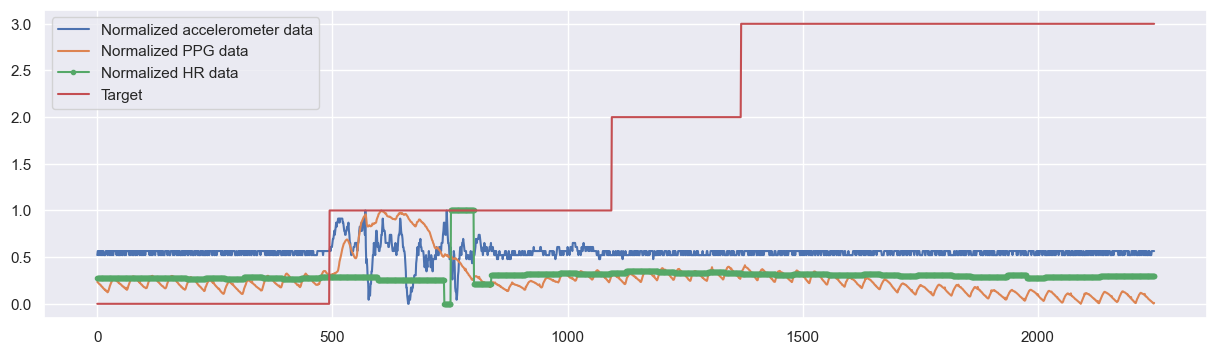

2059


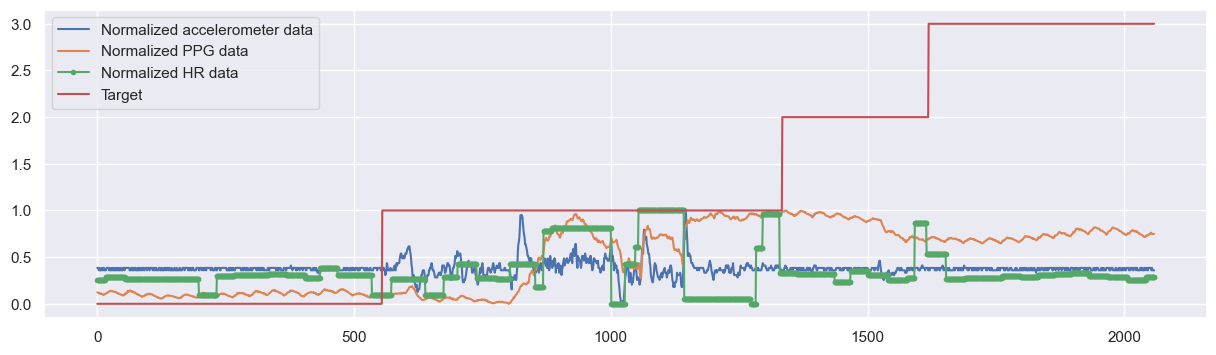

2948


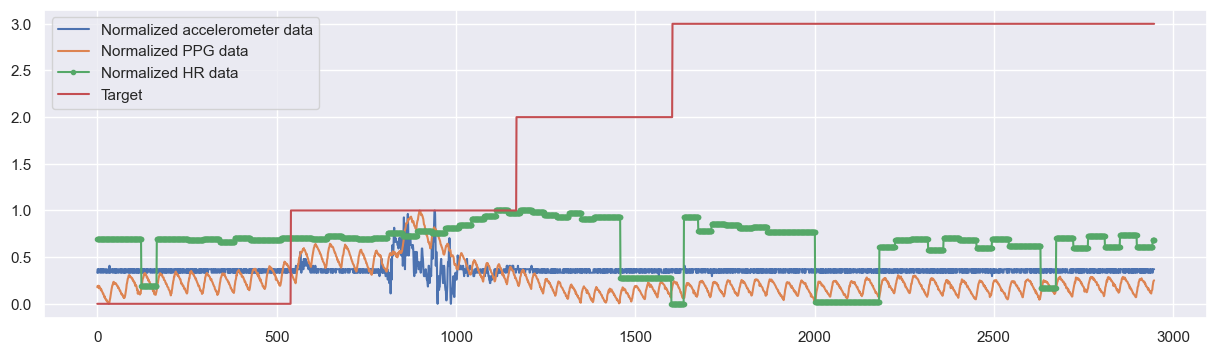

In [8]:
# test
# path = '/Users/alinka/Documents/diploma/orthostatic-hypotension-detection/TRACE-Data-DAAA/'
path = r"C:\Users\almuli\personal\orthostatic-hypotension-detection\TRACE-Data-DAAA"
prefix = 'Trace-'

for i in range(3):
    file_path = join(path, prefix + df.iloc[i]['File Name'] + '.txt')
    df_rec, _ = tlt.read_data(file_path, range=[None, None], verbose=False)
    df_rec = sp.spPPG(df_rec)
    data = get_data(df_rec, df.iloc[i], T_pref='T1')
    ppg, hr, acc, labels = data['ppg_normalized'], data['hr_normalized'], data['acc_normalized'], data['targets']
    # ppg, hr, acc, labels = data['ppg'], data['hr'], data['acc'], data['targets']
    
    print(len(ppg))
    plt.figure(figsize=(15, 4))
    plt.plot(acc, label='Normalized accelerometer data')
    plt.plot(ppg, label='Normalized PPG data')
    plt.plot(hr, '.-', label='Normalized HR data')
    plt.plot(labels, label='Target')
    plt.legend()
    plt.show()

In [12]:
# path = '/Users/alinka/Documents/diploma/orthostatic-hypotension-detection/TRACE-Data-DAAA/'
path = r"C:\Users\almuli\personal\orthostatic-hypotension-detection\TRACE-Data-DAAA"
prefix = 'Trace-'

ppg_data, hr_data, accelerometer_data, targets = [], [], [], []
ppg_not_normalized, hr_not_normalized = [], []

for i in tqdm(range(len(df))):
    file_path = join(path, prefix + df.iloc[i]['File Name'] + '.txt')
    df_rec, _ = tlt.read_data(file_path, range=[None, None], verbose=False)
    df_rec = sp.spPPG(df_rec)

    for tpref in ['T1', 'T2', 'T3']:
        data = get_data(df_rec, df.iloc[i], T_pref=tpref)
        if data is None:
            continue
        ppg, hr, accX, labels = data['ppg_normalized'], data['hr_normalized'], data['acc_normalized'], data['targets']

        accelerometer_data.append(accX)
        ppg_data.append(ppg)
        hr_data.append(hr)
        targets.append(labels)
        
        ppg_not_normalized.append(data['ppg'])
        hr_not_normalized.append(data['hr'])

 68%|██████▊   | 48/71 [18:40<09:10, 23.94s/it]

Empty sequence. No accelerometer data grabbed.


 92%|█████████▏| 65/71 [25:02<02:11, 21.94s/it]

Line 105345: skipping bad data - 12 commas


100%|██████████| 71/71 [27:18<00:00, 23.08s/it]


---

Minimal length of transition stage = 3.1 sec (155 samples)

In [13]:
# Define a function to window the signals and labels
def create_windows(signal_data, label_data, window_size, step_size):
    windows = []
    window_labels = []
    for i in range(len(signal_data)):
        signal, labels = signal_data[i], label_data[i]
        for start in range(0, len(signal) - window_size + 1, step_size):
            end = start + window_size
            window = signal[start:end]
            label = np.bincount(labels[start: end]).argmax()
            windows.append(window)
            window_labels.append(label)

    return np.array(windows), np.array(window_labels)

# Define your window size and step size
sampling_rate = 50
window_size = 3 * sampling_rate
step_size = int(0.5 * window_size)  # 25% overlap

# # Preprocess data and create windows
# accel_windows, accel_labels = create_windows(accelerometer_data, targets, window_size, step_size)
# ppg_windows, _ = create_windows(ppg_data, targets, window_size, step_size)
# hr_windows, _ = create_windows(hr_data, targets, window_size, step_size)


In [14]:
# combined_windows = np.stack((ppg_windows, hr_windows, accel_windows), axis=1)

In [16]:
# print(ppg_data[i])

In [224]:
sequences, sequence_labels = [], []

for i in range(len(ppg_data)):
    ppg, labels = create_windows([ppg_data[i]], [targets[i]], window_size, step_size)
    ppg_nn, _ = create_windows([ppg_not_normalized[i]], [targets[i]], window_size, step_size)
    hr_nn, _ = create_windows([hr_not_normalized[i]], [targets[i]], window_size, step_size)
    hr, _ = create_windows([hr_data[i]], [targets[i]], window_size, step_size)
    acc, _ = create_windows([accelerometer_data[i]], [targets[i]], window_size, step_size)
    
    combined_windows = np.stack((ppg, hr, acc, ppg_nn, hr_nn), axis=1)
    sequences.append(combined_windows)
    sequence_labels.append(labels)


In [225]:
sequences[0][:, :3, :].shape

(28, 3, 150)

In [226]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader

# Custom Dataset
class SequenceDataset(Dataset):
    def __init__(self, sequences, sequence_labels, test_dataset=False):
        self.sequences = sequences
        self.sequence_labels = sequence_labels
        self.test_dataset = test_dataset

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        if self.test_dataset:
            return self.sequences[idx], self.sequence_labels[idx]
        return self.sequences[idx][:, :3, :], self.sequence_labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    
    # Compute the length of each sequence
    lengths = torch.tensor([len(seq) for seq in sequences])
    
    # Pad sequences so they all have the same length
    padded_sequences = pad_sequence([torch.tensor(seq) for seq in sequences], batch_first=True)
    padded_labels = pad_sequence([torch.tensor(l) for l in labels], batch_first=True)
             
    # Sort sequences by length in descending order (required for 'pack_padded_sequence')
    lengths, perm_idx = lengths.sort(0, descending=True)
    padded_sequences = padded_sequences[perm_idx]
    padded_labels = padded_labels[perm_idx]

    return padded_sequences, lengths, padded_labels


In [227]:
seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

X_train, X_val, y_train, y_val = train_test_split(sequences, sequence_labels, test_size=0.175, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.175, random_state=seed)

BATCH_SIZE = 32

g = torch.Generator()
g.manual_seed(seed)

train_dataset = SequenceDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, generator=g)

val_dataset = SequenceDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, generator=g)

test_dataset = SequenceDataset(X_test, y_test, test_dataset=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, generator=g)

In [228]:
print(len(X_train), len(X_val), len(X_test))

143 38 31


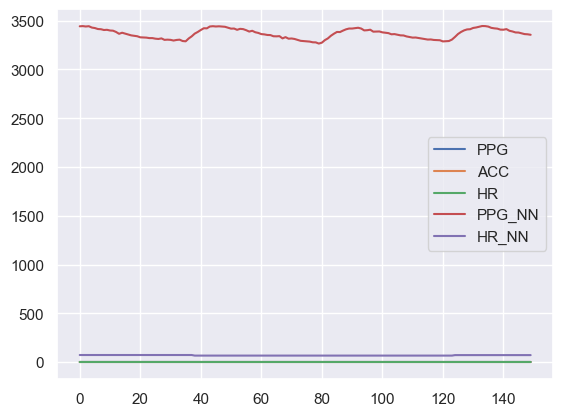

In [230]:
plt.plot(test_dataset[0][0][20].T, label=['PPG', 'ACC', 'HR', 'PPG_NN', 'HR_NN'])
plt.legend()
plt.show()

In [36]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class CNNLSTM(nn.Module):
    def __init__(self, num_classes=4,
                 cnn_dropout=0.5,
                 lstm_hidden_size=128,
                 lstm_bidirectional=True,
                 lstm_dropout=0.5,
                 lstm_num_layers=2,
                 **kwargs):
        super(CNNLSTM, self).__init__()
        
        # Assuming a simple CNN for demonstration; adjust according to your specific architecture
        self.cnn = nn.Sequential(
            nn.Conv1d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )
        self.dropout = nn.Dropout(p=cnn_dropout)
        cnn_output_size = 2368

        self.lstm = nn.LSTM(input_size=cnn_output_size, 
                            hidden_size=lstm_hidden_size, 
                            num_layers=lstm_num_layers,
                            bidirectional=lstm_bidirectional, 
                            dropout=lstm_dropout if lstm_num_layers > 1 else 0, 
                            batch_first=True)

        self.fc = nn.Linear(lstm_hidden_size * 2 if lstm_bidirectional else lstm_hidden_size, num_classes)

    def forward(self, x, lengths):
        batch_size, num_windows, channels, window_size = x.shape
        # Reshape x to treat each window as a separate sample
        x = x.view(-1, channels, window_size)
        # Process each window with the CNN
        cnn_out = self.cnn(x)
        cnn_out = self.dropout(cnn_out)
        cnn_out = cnn_out.view(batch_size, num_windows, -1)

        x_packed = pack_padded_sequence(cnn_out, lengths, batch_first=True, enforce_sorted=False)
        
        # LSTM layers
        lstm_out, _ = self.lstm(x_packed)
        
        # Unpack the sequence
        output, output_lengths = pad_packed_sequence(lstm_out, batch_first=True)

        # We only take the output of the last time step for classification
        final_out = self.fc(output)
        return final_out

In [37]:
import random
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import torch 
import torch.backends.cudnn 
import torch.cuda

def set_determenistic_mode(SEED, disable_cudnn):
  torch.manual_seed(SEED)                       # Seed the RNG for all devices (both CPU and CUDA).
  random.seed(SEED)                             # Set python seed for custom operators.
  rs = RandomState(MT19937(SeedSequence(SEED))) # If any of the libraries or code rely on NumPy seed the global NumPy RNG.
  np.random.seed(SEED)             
  torch.cuda.manual_seed_all(SEED)              # If you are using multi-GPU. In case of one GPU, you can use # torch.cuda.manual_seed(SEED).

  if not disable_cudnn:
    torch.backends.cudnn.benchmark = False    # Causes cuDNN to deterministically select an algorithm, 
                                              # possibly at the cost of reduced performance 
                                              # (the algorithm itself may be nondeterministic).
    torch.backends.cudnn.deterministic = True # Causes cuDNN to use a deterministic convolution algorithm, 
                                              # but may slow down performance.
                                              # It will not guarantee that your training process is deterministic 
                                              # if you are using other libraries that may use nondeterministic algorithms 
  else:
    torch.backends.cudnn.enabled = False # Controls whether cuDNN is enabled or not. 
                                         # If you want to enable cuDNN, set it to True.

In [117]:
hyperPARAMS = {'cnn_dropout': 0.25,
 'lstm_hidden_size': 210,
 'lstm_bidirectional': True,
 'lstm_dropout': 0.25419684055130065,
 'lstm_num_layers': 2,
 'learning_rate': 0.009728535043244946,
 'weight_decay': 7.254576818661595e-05}

In [186]:
# seed = 777
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(seed)
# 
# 
# set_determenistic_mode(seed, True)

model = CNNLSTM(**hyperPARAMS).cuda()

class_counts = np.bincount(np.concatenate(y_train).ravel())
class_weights = class_counts.sum() / (len(class_counts) * class_counts)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=hyperPARAMS['learning_rate'], weight_decay=hyperPARAMS['weight_decay'])

history = {'train_loss': [], 'train_acc': [],
           'val_loss': [], 'val_acc': []}


num_epochs = 200
for epoch in range(num_epochs):
    train_losses, train_acc = [], []
    model.train()
    for padded_sequences, lengths, labels in train_loader:
        # Move data to the appropriate device (e.g., GPU)
        padded_sequences = padded_sequences.to(device)
        
        optimizer.zero_grad()
        outputs = model(padded_sequences.float().to(device), lengths)

        loss = criterion(outputs.view(-1, 4), labels.long().view(-1).to(device))
        loss.backward()
        optimizer.step()
    
        train_losses.append(loss.item())
        
        _, predicted = torch.max(outputs.view(-1, 4), 1)
        accuracy = accuracy_score(labels.view(-1).numpy(), predicted.cpu().detach().numpy())
        train_acc.append(accuracy)
    
    avg_train_loss = np.mean(train_losses)
    history['train_loss'].append(avg_train_loss)
    avg_train_accuracy = np.mean(train_acc)
    history['train_acc'].append(avg_train_accuracy)
    
    # Validation
    model.eval()  # Set the model to evaluation mode
    val_losses, val_acc = [], []

    with torch.no_grad():  # No need to track the gradients
        for padded_sequences, lengths, labels in val_loader:
            outputs = model(padded_sequences.float().to(device), lengths)
            loss = criterion(outputs.view(-1, 4), labels.long().view(-1).to(device))
            val_losses.append(loss.item())

            _, predicted = torch.max(outputs.view(-1, 4), 1)
            accuracy = accuracy_score(labels.view(-1).numpy(), predicted.cpu().detach().numpy())
            val_acc.append(accuracy)

    # Compute the average loss and accuracy over the validation set
    avg_val_loss = np.mean(val_losses)
    history['val_loss'].append(avg_val_loss)
    avg_val_accuracy = np.mean(val_acc)
    history['val_acc'].append(avg_val_accuracy)
    
    # scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}]\tTrain Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy:.4f}')


Epoch [1/200]	Train Loss: 1.5816, Validation Loss: 1.3251, Validation Accuracy: 0.6735
Epoch [2/200]	Train Loss: 1.2790, Validation Loss: 1.2252, Validation Accuracy: 0.7307
Epoch [3/200]	Train Loss: 1.1540, Validation Loss: 1.0936, Validation Accuracy: 0.7734
Epoch [4/200]	Train Loss: 1.0168, Validation Loss: 1.1429, Validation Accuracy: 0.6939
Epoch [5/200]	Train Loss: 1.0161, Validation Loss: 0.9115, Validation Accuracy: 0.8477
Epoch [6/200]	Train Loss: 0.8724, Validation Loss: 0.8148, Validation Accuracy: 0.8676
Epoch [7/200]	Train Loss: 0.8000, Validation Loss: 0.9948, Validation Accuracy: 0.7538
Epoch [8/200]	Train Loss: 0.8366, Validation Loss: 0.8437, Validation Accuracy: 0.7885
Epoch [9/200]	Train Loss: 0.7710, Validation Loss: 0.7534, Validation Accuracy: 0.8414
Epoch [10/200]	Train Loss: 0.7286, Validation Loss: 0.6801, Validation Accuracy: 0.8851
Epoch [11/200]	Train Loss: 0.6644, Validation Loss: 0.6251, Validation Accuracy: 0.8979
Epoch [12/200]	Train Loss: 0.6353, Valida

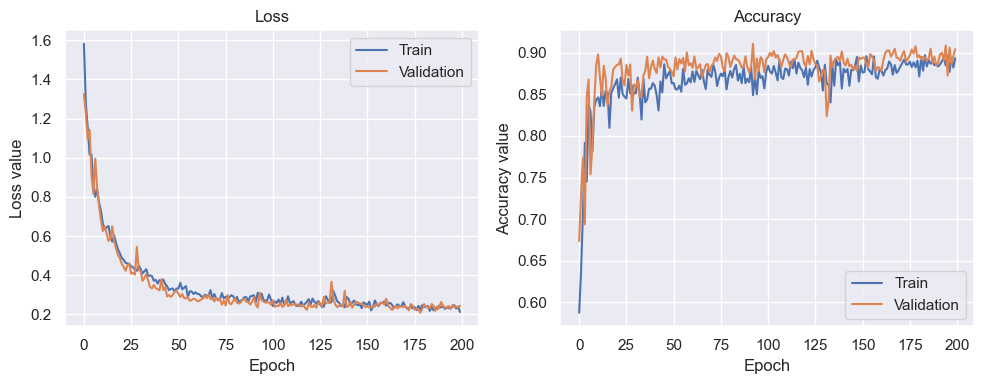

In [187]:

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
axs[0].plot(history['train_loss'], label='Train')
axs[0].plot(history['val_loss'], label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss value')
axs[0].set_title('Loss')
axs[0].legend()

axs[1].plot(history['train_acc'], label='Train')
axs[1].plot(history['val_acc'], label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy value')
axs[1].set_title('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

Accuracy: 92.31%, F1 score: 92.41%


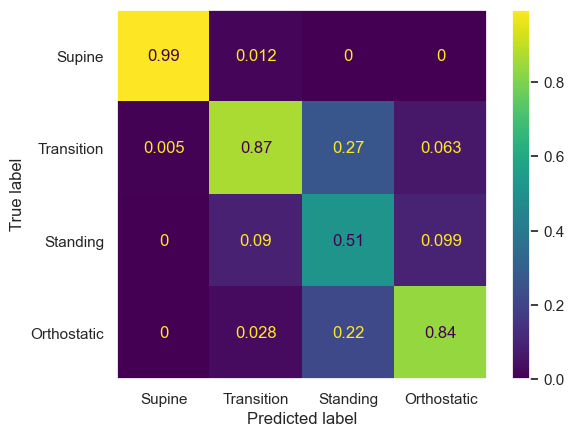

In [231]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


alll = {'true': np.array([]), 'pred': np.array([])}
with torch.no_grad():  # No need to track the gradients
    for padded_sequences, lengths, labels in test_loader:
        padded_sequences = padded_sequences[:, :, :3, :]
        outputs = model(padded_sequences.float().to(device), lengths)
        _, predicted = torch.max(outputs.view(-1, 4), 1)
        alll['true'] = np.append(alll['true'], labels)
        alll['pred'] = np.append(alll['pred'], predicted.cpu().detach().numpy())
     
accuracy = accuracy_score(alll['true'], alll['pred'])
f1_score = f1_score(alll['true'], alll['pred'], average='weighted')
print(f'Accuracy: {round(accuracy * 100, 2)}%, F1 score: {round(f1_score * 100, 2)}%')

cm = confusion_matrix(alll['true'], alll['pred'], normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Supine', 'Transition', 'Standing', 'Orthostatic'])
fig, ax = plt.subplots()
ax.grid(False)
disp.plot(ax=ax)
plt.show()

In [189]:
# acc_str = '92-31'
# torch.save(model, f'chpk/model-{acc_str}.pth')
# 
# import json
# json_object = json.dumps(history, indent=4)
# with open(f'chpk/history-{acc_str}.json', "w") as outfile:
#     outfile.write(json_object)

## Visualisation

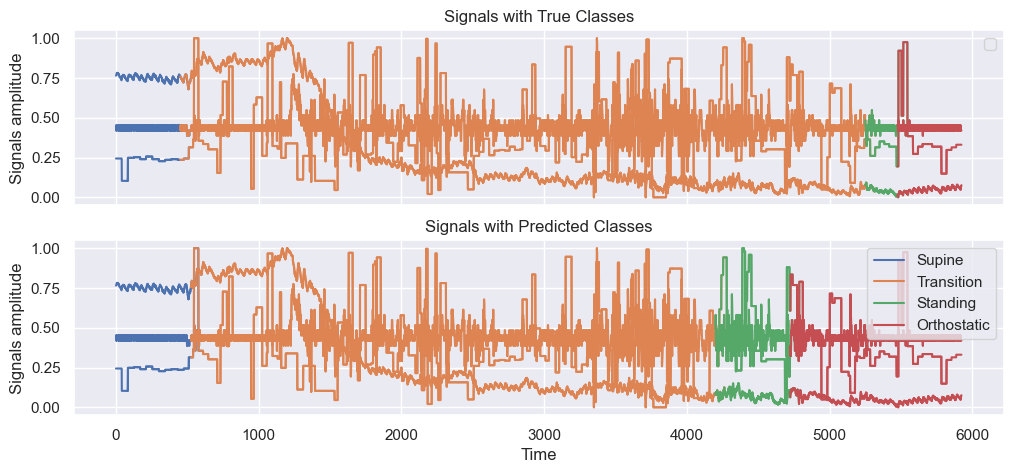

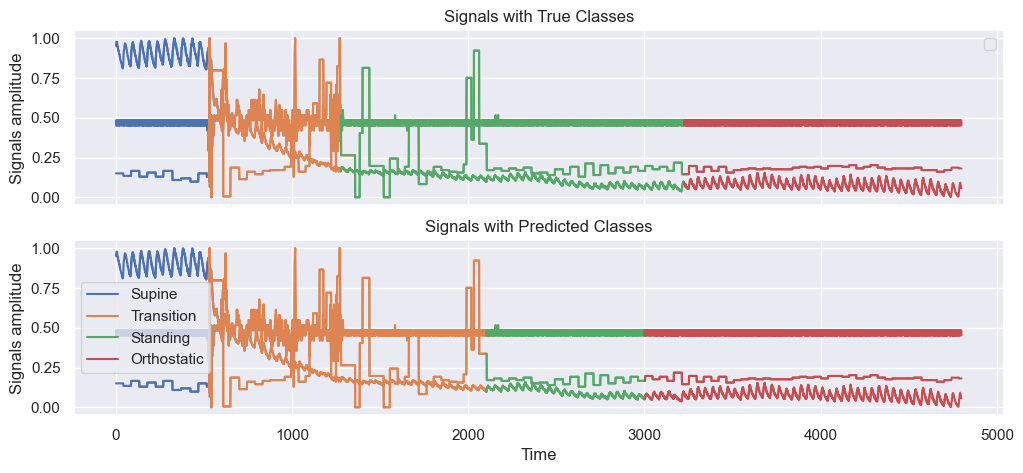

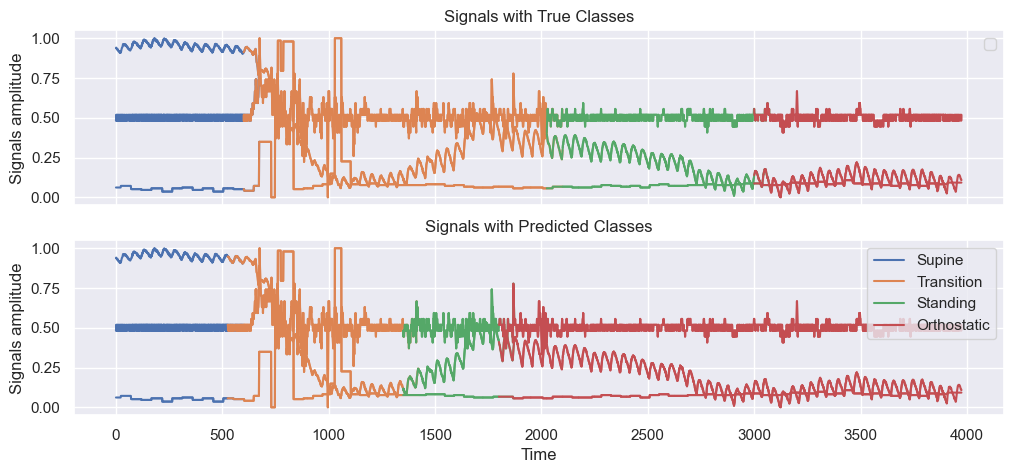

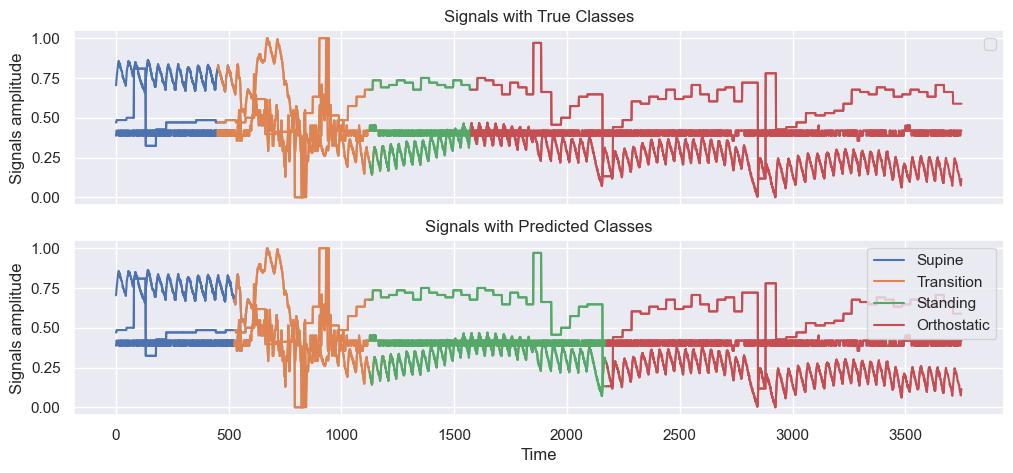

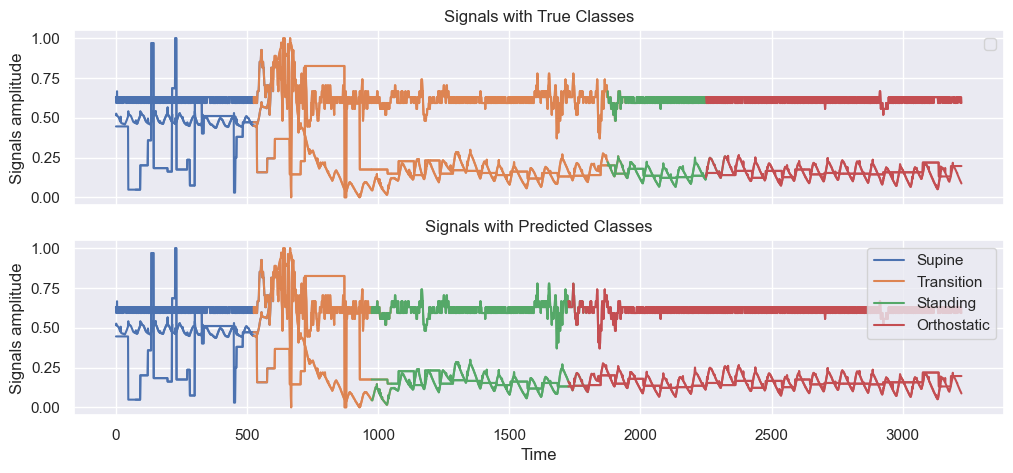

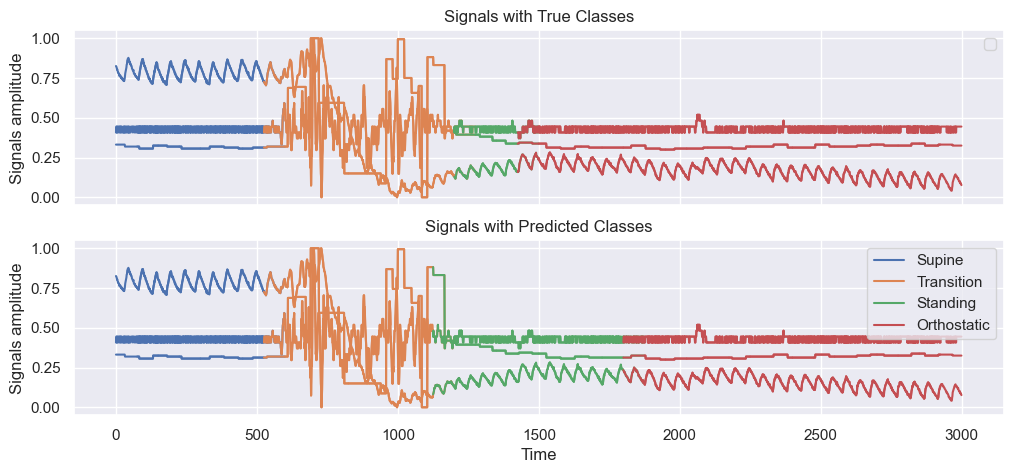

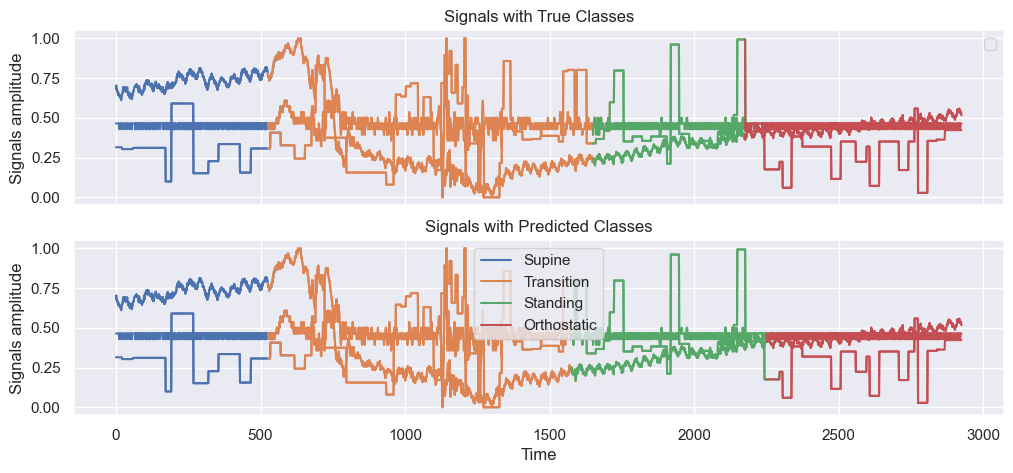

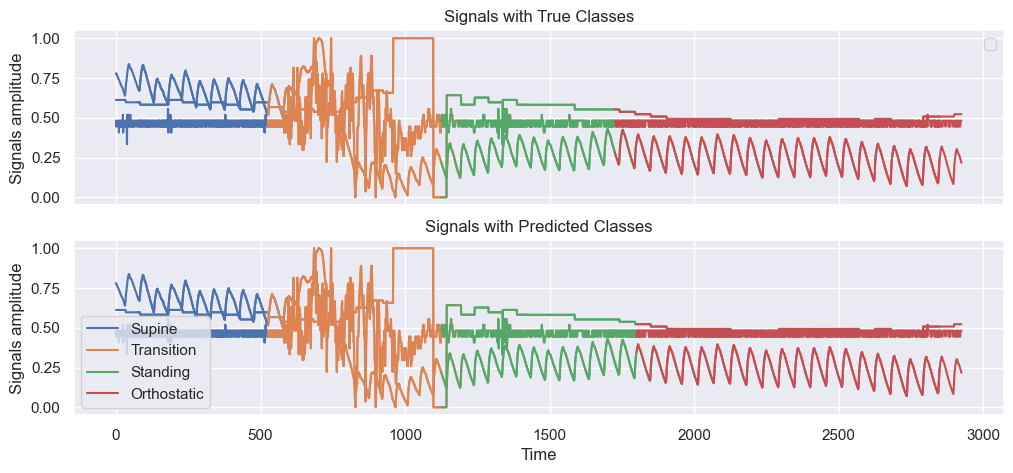

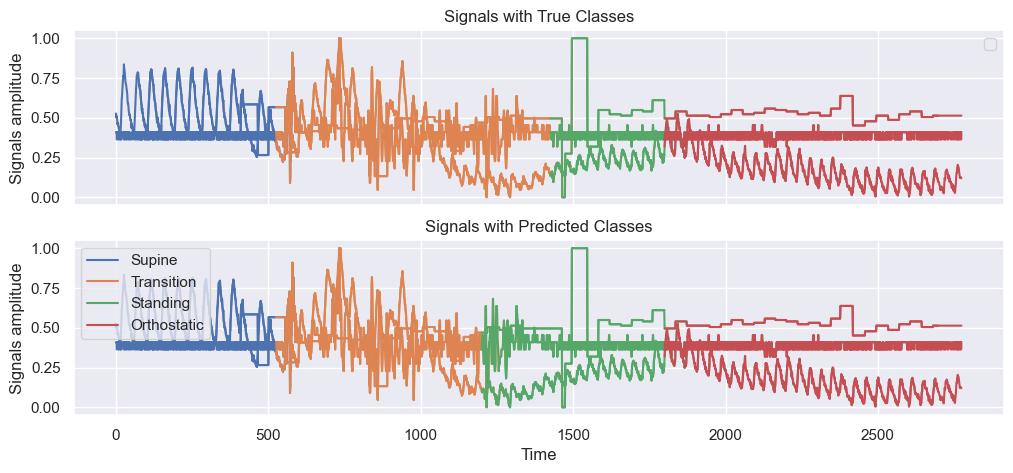

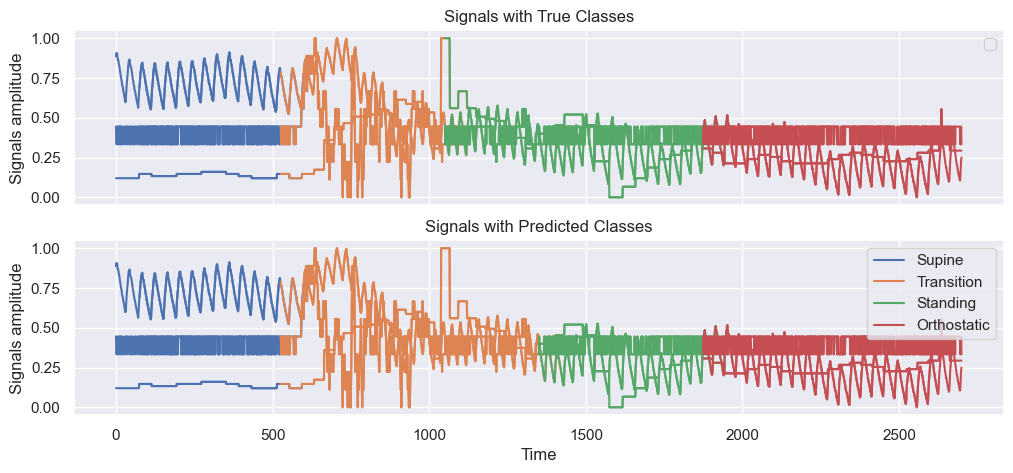

In [190]:
import matplotlib.pyplot as plt

colors = sns.color_palette()
labels_names = ['Supine', 'Transition', 'Standing', 'Orthostatic']


for padded_sequences, lengths, labels in test_loader:
    padded_sequences = padded_sequences[:, :, :3, :]
    for record_num in range(0, 10):
        outputs = model(padded_sequences.float().to(device), lengths)
        _, predicted = torch.max(outputs.view(-1, 4), 1)
        
        added_labels = set()
        current_len = lengths[record_num]
        windows, true_labels, window_predictions = padded_sequences[record_num][:current_len], labels[record_num][:current_len], predicted[record_num * 78: record_num*78+78][:current_len]
        
        
        fig, axs = plt.subplots(nrows=2, figsize=(12, 5), sharex=True)
        for i, (window, prediction) in enumerate(zip(windows, true_labels)):
            start_index = i * step_size
            end_index = start_index + window_size
            time_indices = np.arange(start_index, end_index)
            # print(time_indices.shape, window.shape, prediction.cpu().item(), labels_names[prediction.cpu().item()])
            label = labels_names[prediction.cpu().item()] if prediction not in added_labels else ''
            axs[0].plot(time_indices, window.T.cpu(), color=colors[prediction.cpu().item()], label=label)
            added_labels.add(prediction)
            
        # Remove duplicate labels from the legend
        handles, legend_labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(legend_labels, handles))
        axs[0].legend(by_label.values(), by_label.keys())
        
        axs[0].set_ylabel('Signals amplitude')
        axs[0].set_title('Signals with True Classes')
        
        # -------------------------------------------
        added_labels = set()
    
        for i, (window, prediction) in enumerate(zip(windows, window_predictions)):
            start_index = i * step_size
            end_index = start_index + window_size
            time_indices = np.arange(start_index, end_index)
            label = labels_names[prediction.cpu().item()] if prediction not in added_labels else ''
            axs[1].plot(time_indices, window.T.cpu(), color=colors[prediction.cpu().item()], label=label)
            added_labels.add(prediction)
            
        # Remove duplicate labels from the legend
        handles, legend_labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(legend_labels, handles))
        axs[1].legend(by_label.values(), by_label.keys())
        
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Signals amplitude')
        axs[1].set_title('Signals with Predicted Classes')
        
        plt.show()

In [232]:
SIGNALS_FOR_BIOMETRICS_all = []

for padded_sequences, lengths, labels in test_loader:

    for record_num in range(len(padded_sequences)):
        outputs = model(padded_sequences[:, :, :3, :].float().to(device), lengths)
        _, predicted = torch.max(outputs.view(-1, 4), 1)
        
        added_labels = set()
        current_len = lengths[record_num]
        windows, true_labels, window_predictions = padded_sequences[record_num][:current_len], labels[record_num][:current_len], predicted[record_num * 78: record_num*78+78][:current_len]
        
        SIGNALS_FOR_BIOMETRICS = {'ppg': np.array([]),
                                  'hr': np.array([]),
                                  'ppg_normalized': np.array([]),
                                  'true_labels': [],
                                  'predicted_labels': []}
        
        for i, (window, prediction) in enumerate(zip(windows, true_labels)):
            
            SIGNALS_FOR_BIOMETRICS['ppg'] = np.append(SIGNALS_FOR_BIOMETRICS['ppg'], window.cpu()[3, :int(window_size * 0.5)])
            SIGNALS_FOR_BIOMETRICS['hr'] = np.append(SIGNALS_FOR_BIOMETRICS['hr'], window.cpu()[4, :int(window_size * 0.5)])
            for _ in range(window_size - int(window_size * 0.5)):
                SIGNALS_FOR_BIOMETRICS['true_labels'].append(prediction.item())
            
            if i == len(windows) - 1:
                SIGNALS_FOR_BIOMETRICS['ppg'] = np.append(SIGNALS_FOR_BIOMETRICS['ppg'], window.cpu()[3, int(window_size * 0.5):])
                SIGNALS_FOR_BIOMETRICS['hr'] = np.append(SIGNALS_FOR_BIOMETRICS['hr'], window.cpu()[4, int(window_size * 0.5):])
                for _ in range(window_size - int(window_size * 0.5)):
                    SIGNALS_FOR_BIOMETRICS['true_labels'].append(prediction.item())
            


        for i, (window, prediction) in enumerate(zip(windows, window_predictions)):
            
            for _ in range(window_size - int(window_size * 0.5)):
                SIGNALS_FOR_BIOMETRICS['predicted_labels'].append(prediction.item())
            if i == len(windows) - 1:
                for _ in range(window_size - int(window_size * 0.5)):
                    SIGNALS_FOR_BIOMETRICS['predicted_labels'].append(prediction.item())
        
        SIGNALS_FOR_BIOMETRICS_all.append(SIGNALS_FOR_BIOMETRICS)


## Calculate biometrics

In [233]:
from sklearn.metrics import mean_absolute_error

### OHV1

In [193]:
def calculate_ohv1_mae(signals_for_biometrics):
    ohv1_true_array, ohv1_pred_array = [], []
    for signal in signals_for_biometrics:
        try:
            mask = np.where(np.array(signal['true_labels']) == 0)
            min_supine = min(signal['ppg'][mask])
            mask = np.where(np.array(signal['true_labels']) == 2)
            min_standing = min(signal['ppg'][mask])
            ohv1_true = abs(min_standing - min_supine)
            
            
            mask = np.where(np.array(signal['predicted_labels']) == 0)
            min_supine = min(signal['ppg'][mask])
            mask = np.where(np.array(signal['predicted_labels']) == 2)
            min_standing = min(signal['ppg'][mask])
            
            ohv1_true_array.append(ohv1_true)
            ohv1_pred_array.append(abs(min_standing - min_supine))
        except ValueError:
            continue
    
    return mean_absolute_error(ohv1_true_array, ohv1_pred_array)

In [194]:
calculate_ohv1_mae(SIGNALS_FOR_BIOMETRICS_all)

98.43478260869566

### OHV2

In [195]:
def calculate_ohv2_mae(signas_for_biometrics):
    ohv2_true_array, ohv2_pred_array = [], []
    
    for signal in signas_for_biometrics:
        try:
            mask = np.where(np.array(signal['true_labels']) == 0)
            min_supine = min(signal['ppg'][mask])
            mask = np.where(np.array(signal['true_labels']) == 3)
            min_standing = min(signal['ppg'][mask])
            ohv2_true = abs(min_standing - min_supine)
            
            
            mask = np.where(np.array(signal['predicted_labels']) == 0)
            min_supine = min(signal['ppg'][mask])
            mask = np.where(np.array(signal['predicted_labels']) == 3)
            min_standing = min(signal['ppg'][mask])
            
            ohv2_true_array.append(ohv2_true)
            ohv2_pred_array.append(abs(min_standing - min_supine))
        except ValueError:
            continue
    
    return mean_absolute_error(ohv2_true_array, ohv2_pred_array)

In [196]:
calculate_ohv2_mae(SIGNALS_FOR_BIOMETRICS_all)

20.838709677419356

### OTC

In [197]:
def calculate_otc_mae(signas_for_biometrics):
    otc_true_array, otc_pred_array = [], []
    
    for signal in signas_for_biometrics:
        try:
            start_transition = signal['true_labels'].index(1)
            orthostatis_archieved_at = signal['true_labels'].index(2)
            otc_true = abs(orthostatis_archieved_at - start_transition) / sampling_rate
            
            start_transition = signal['predicted_labels'].index(1)
            orthostatis_archieved_at = signal['predicted_labels'].index(2)
    
            otc_true_array.append(otc_true)
            otc_pred_array.append(abs(orthostatis_archieved_at - start_transition) / sampling_rate)
        except ValueError:
            continue
    
    return mean_absolute_error(otc_true_array, otc_pred_array)

In [198]:
calculate_otc_mae(SIGNALS_FOR_BIOMETRICS_all)

5.608695652173913

### POT

In [241]:
def calculate_pot_mae(signas_for_biometrics):
    pot_true_array, pot_pred_array = [], []
    for signal in signas_for_biometrics:
        try:
            mask = np.where(np.array(signal['true_labels']) == 0)
            avg_supine = np.mean(signal['hr'][mask])
            mask = np.where((np.array(signal['true_labels']) == 2) | (np.array(signal['true_labels']) == 3))
            max_standing_orthostatis = max(signal['hr'][mask])
            pot_true = abs(max_standing_orthostatis - avg_supine)
            
            mask = np.where(np.array(signal['predicted_labels']) == 0)
            avg_supine = np.mean(signal['hr'][mask])
            mask = np.where((np.array(signal['predicted_labels']) == 2) | (np.array(signal['predicted_labels']) == 3))
            max_standing_orthostatis = max(signal['hr'][mask])
            
            pot_true_array.append(pot_true)
            pot_pred_array.append(abs(max_standing_orthostatis - avg_supine))

        except:
            continue
    
    return mean_absolute_error(pot_true_array, pot_pred_array)

In [242]:
calculate_pot_mae(SIGNALS_FOR_BIOMETRICS_all)

21.183750128008192

### Hyper parameters fine tuning

In [140]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import random

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

X_train, X_val, y_train, y_val = train_test_split(sequences, sequence_labels, test_size=0.175, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.175, random_state=seed)

BATCH_SIZE = 32
# Instantiate your custom dataset
train_dataset = SequenceDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_dataset = SequenceDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


def objective(trial):
    # cnn_kernel_size = trial.suggest_float('cnn_dropout', 0.25, 0.8)
    cnn_dropout = trial.suggest_float('cnn_dropout', 0.25, 0.8)
    lstm_hidden_size = trial.suggest_int('lstm_hidden_size', 100, 512)
    lstm_bidirectional = trial.suggest_categorical('lstm_bidirectional', [True, False])
    lstm_dropout = trial.suggest_float('lstm_dropout', 0.25, 0.8)
    lstm_num_layers = trial.suggest_int('lstm_num_layers', 1, 5)

    learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)
    

    model = CNNLSTM(
                 cnn_dropout=cnn_dropout,
                 lstm_hidden_size=lstm_hidden_size,
                 lstm_bidirectional=lstm_bidirectional,
                 lstm_dropout=lstm_dropout,
                 lstm_num_layers=lstm_num_layers
            ).to(device)
    

    class_counts = np.bincount(np.concatenate(y_train).ravel())
    class_weights = class_counts.sum() / (len(class_counts) * class_counts)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    num_epochs = 100
    avg_val_loss = 0
    for epoch in range(num_epochs):
        model.train()
        for padded_sequences, lengths, labels in train_loader:
            padded_sequences = padded_sequences.to(device)
            
            optimizer.zero_grad()
            outputs = model(padded_sequences.float().to(device), lengths)
    
            loss = criterion(outputs.view(-1, 4), labels.long().view(-1).to(device))
            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode
        val_acc = []
    
        with torch.no_grad():  # No need to track the gradients
            for padded_sequences, lengths, labels in val_loader:
                outputs = model(padded_sequences.float().to(device), lengths)
                _, predicted = torch.max(outputs.view(-1, 4), 1)
                accuracy = accuracy_score(labels.view(-1).numpy(), predicted.cpu().detach().numpy())
                val_acc.append(accuracy)
    
        avg_val_acc = np.mean(val_acc)     
        trial.report(avg_val_acc, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return avg_val_acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

C:\Users\almuli\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-03-07 23:56:12,533] A new study created in memory with name: no-name-3a43ef6b-aeaf-45a8-a52b-cb1f250a6b32
[I 2024-03-07 23:56:28,934] Trial 0 finished with value: 0.21355220985155196 and parameters: {'cnn_dropout': 0.5842091476352187, 'lstm_hidden_size': 415, 'lstm_bidirectional': True, 'lstm_dropout': 0.722252208097054, 'lstm_num_layers': 2, 'learning_rate': 1.6424971483335808e-06, 'weight_decay': 1.050633103408865e-05}. Best is trial 0 with value: 0.21355220985155196.
[I 2024-03-07 23:56:37,885] Trial 1 finished with value: 0.8507875759109311 and parameters: {'cnn_dropout': 0.252151221284183, 'lstm_hidden_size': 269, 'lstm_bidirectional': False, 'lstm_dropout': 0.6329123641926218, 'lstm_num_layers': 2,

Best trial:
  Value: 0.8889117324561404
  Params: 
    cnn_dropout: 0.3829527693581315
    lstm_hidden_size: 410
    lstm_bidirectional: True
    lstm_dropout: 0.2795003006222976
    lstm_num_layers: 2
    learning_rate: 0.0011910229422519693
    weight_decay: 0.0021211328270079786


In [141]:
dict(trial.params.items())

{'cnn_dropout': 0.3829527693581315,
 'lstm_hidden_size': 410,
 'lstm_bidirectional': True,
 'lstm_dropout': 0.2795003006222976,
 'lstm_num_layers': 2,
 'learning_rate': 0.0011910229422519693,
 'weight_decay': 0.0021211328270079786}

#### Evaluation...

In [102]:
colors = sns.color_palette('colorblind')

In [67]:
def plot_lol(signals, outputs, labels):

    for i in range(len(signals)):
        predicted_classes = outputs[i]

        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13, 5), sharex=True)

        start_index = 0
        data = signals[i].T
        labelss = labels[i]
        for i in range(1, len(labelss)):
            if labelss[i] != labelss[i-1] or i == len(labelss)-1:
                # Plot the segment
                ax1.plot(range(start_index, i+1), data[start_index:i+1], 
                         label=stages[labelss[i - 1].item()],
                         color=colors[labelss[i - 1].item()])
                start_index = i
        ax1.set_title('True stages')
        ax1.legend()
        
        
        start_index = 0
        for i in range(1, len(predicted_classes)):
            if predicted_classes[i] != predicted_classes[i-1] or i == len(predicted_classes) - 1:
                # Plot the segment
                ax2.plot(range(start_index, i+1), data[start_index:i+1],
                         # label=stages[predicted_classes[i - 1].item()],
                         color=colors[predicted_classes[i - 1].item()])
                start_index = i

        ax2.set_title('Predicted stages')
        plt.xlabel('Time points')
        plt.tight_layout()
        plt.show()

In [ ]:
model.eval()
with torch.no_grad():
    for _, (signals, labels) in enumerate(val_loader):
        outputs = model(signals)

        plot_lol(signals, outputs, labels)
